In [ ]:
from collections import Counter
from functools import partial
from modules.gradient_descent import minimize_stochastic
from modules.simple_linear_regression import total_sum_of_squares
import math, random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import t
from scipy.stats import norm

# Regressão Múltipla

Embora a diretora da empresa esteja bastante impressionada com seu modelo preditivo, ela acha que você pode fazer melhor. Para isso, você coletou dados adicionais: para cada um dos seus usuários, você sabe quantas horas ele trabalha todos os dias e se ele tem um PhD. Você gostaria de usar esses dados adicionais para melhorar seu modelo.

Assim, você hipotetiza um modelo linear com mais variáveis independentes:

minutos = $\alpha + \beta_1$ friends + $\beta_2$ horas de trabalho + $\beta_3$ phd + $\epsilon$

Obviamente, se um usuário tem um PhD não é um número, mas - como mencionamos na Aula 10 - podemos introduzir uma variável dummy que é igual a 1 para usuários com PhDs e 0 para usuários sem. Depois disso, a variável é tão numérica quanto as outras.

# O modelo

Lembre-se de que, na Aula 13, ajustamos um modelo da seguinte forma:

$$y_i = \alpha + \beta x_i + \epsilon_i$$

Agora imagine que cada entrada $x_i$ não é um simples número, mas um vetor de $k$ números $x_{i1}, \cdots, x_{ik}$. O modelo de regressão múltipla assume que:

$$y_i = \alpha + \beta_{i1} x_{i1} + \cdots + \beta_{ik} x_{ik} + \epsilon_i$$

Na regressão múltipla, o vetor de parâmetros é geralmente chamado de $\beta$. Também queremos que isso inclua o termo constante, o que podemos conseguir adicionando uma coluna de dados aos nossos dados:

`beta = [alpha, beta_1, ..., beta_k]`

e:

`x_i = [1, x_i1, ..., x_ik]`

Então, o nosso modelo é simplesmente:

In [ ]:
def predict(x_i, beta):

    """assumes that the first element of each x_i is 1"""
    return np.dot(x_i, beta)

Nesse caso particular, nossa variável independente $x$ será uma lista de vetores, cada qual se parecendo com:

```
[1,  # constant term
 49, # number of friends
 4,  # work hours per day
 0]  # doesn't have PhD
```

Esses dados estão convenientemente salvos [aqui](https://www.dropbox.com/s/ixa4gtd0592jd24/multiple_dailyminutes.csv?dl=0).

In [ ]:
df = pd.read_csv('./data/multiple_dailyminutes.csv')
df

,constant_term,daily_minutes,num_friends,phd,work_hours
0,1,68.77,49,0,4
1,1,51.25,41,0,9
2,1,52.08,40,0,8
3,1,38.36,25,0,6
4,1,44.54,21,0,1
5,1,57.13,21,0,0
6,1,51.40,19,0,3
7,1,41.42,19,0,0
8,1,31.22,18,0,9
9,1,34.76,18,0,8


In [ ]:
x = df[['constant_term','num_friends','work_hours','phd']].values
daily_minutes_good = df['daily_minutes'].values

## Suposições Adicionais do Modelo dos Mínimos Quadrados

Há algumas outras suposições que são necessárias para que esse modelo (e nossa solução) façam sentido.

A primeira é que as colunas de $x$ são linearmente independentes, ou seja, que não há como escrever qualquer uma delas como uma soma ponderada de algumas das outras. Se essa suposição falhar, é impossível estimar o $\beta$. Para ver isso em um caso extremo, imagine que temos um campo extra `num_acquaintances` em nossos dados que para cada usuário era exatamente igual a `num_friends`.

Então, começando com qualquer $\beta$, se adicionarmos *qualquer* valor ao coeficiente de `num_friends` e subtrairmos o mesmo valor do coeficiente de `num_acquaintances`, as previsões do modelo permanecerão inalteradas. O que significa que não há como encontrar o coeficiente para `num_friends`. (Normalmente, as violações dessa suposição não serão tão óbvias.)

A segunda suposição importante é que as colunas de $x$ são todas não correlacionadas com os erros $\epsilon$. Se isso não acontecer, nossas estimativas de $\beta$ serão sistematicamente erradas.

Por exemplo, na Aula 13 construímos um modelo que previa que cada amigo adicional estava associado a um acréscimo de 0,90 minutos diários no site.

Imagine que também é o caso que:

* Pessoas que trabalham mais horas gastam menos tempo no site.

* Pessoas com mais amigos tendem a trabalhar mais horas.

Ou seja, imagine que o modelo "real" seja:

minutos = $\alpha$ + $\beta_1$ amigos + $\beta_2$ horas de trabalho + $\epsilon$

e que horas de trabalho e amigos estão positivamente correlacionados. Nesse caso, quando minimizamos os erros do modelo de variável única:

minutos = $\alpha$ + $\beta_1$ amigos + $\epsilon$

vamos subestimar $\beta_1$.

Pense no que aconteceria se fizéssemos previsões usando o modelo de variável única com o valor "real" de $\beta_1$. (Ou seja, o valor que resulta da minimização dos erros do que chamamos de modelo "real".) As previsões tendem a ser grandes demais para usuários que trabalham muitas horas e pequenas demais para usuários que trabalham poucas horas, porque $\beta_2 < 0$ e nós "esquecemos" de incluí-lo. Como as horas de trabalho estão correlacionadas positivamente com o número de amigos, isso significa que as previsões tendem a ser grandes demais para usuários com muitos amigos e pequenas demais para usuários com poucos amigos. Ou seja, o erro $\epsilon$ da previsão está correlacionado com a variável independente "amigos".

O resultado disso é que podemos reduzir os erros (no modelo de variável única) aumentando nossa estimativa de $\beta_1$, o que significa que o $\beta_1$ minimizador de erros é menor que o valor "real". Ou seja, neste caso, a solução de mínimos quadrados de variável única é tendenciosa para subestimar $\beta_1$. E, em geral, sempre que as variáveis independentes estiverem correlacionadas com erros como este, nossa solução de mínimos quadrados nos dará uma estimativa tendenciosa de $\beta$.

Se você está com dificuldades para entender isso, imagine o que acontece quando ajustamos os dois modelos aos seguintes dados:

|minutos|amigos|horas de trabalho|
|--------------------------------|
|200|50|10|
|195|52|11|
|150|40|5|

Note que as colunas "amigos" e "horas de trabalho" são correlacionadas positivamente, que "amigos" está correlacionado positivamente com "minutos" ($\beta_1 > 0$) e "horas de trabalho", negativamente ($\beta_2 < 0$).

## Ajustando o modelo

Como fizemos no modelo linear simples, escolheremos `beta` para minimizar a soma dos erros quadrados. Encontrar uma solução exata não é simples de fazer à mão, o que significa que precisaremos usar o gradiente descendente. Começaremos criando uma função de erro para minimizar. Para o gradiente descendente estocástico, queremos apenas que o erro ao quadrado corresponda a uma única previsão:

In [ ]:
def error(x_i, y_i, beta):
    return y_i - predict(x_i, beta)

def squared_error(x_i, y_i, beta):
    return error(x_i, y_i, beta) ** 2

Se você sabe cálculo, você pode calcular:

In [ ]:
def squared_error_gradient(x_i, y_i, beta):
    """the gradient corresponding to the ith squared error term"""
    return [-2 * x_ij * error(x_i, y_i, beta)
            for x_ij in x_i]


Caso contrário, você precisa confiar em minha palavra.

Neste momento, estamos prontos para encontrar o `beta` ideal usando a gradiente descendente estocástico:

In [ ]:
def estimate_beta(x, y):
    beta_initial = [random.random() for x_i in x[0]]
    return minimize_stochastic(squared_error,
                               squared_error_gradient,
                               x, y,
                               beta_initial,
                               0.001)

In [ ]:
random.seed(0)
beta = estimate_beta(x, daily_minutes_good)
print(beta)

[30.6198817   0.97020565 -1.86719139  0.91637116]


Isso significa que o nosso modelo é:

minutos = $30.62$ + $0.97$ friends - $1.87$ horas de trabalho + $0.92$ phd

# Interpretando o modelo

Você deve pensar nos coeficientes do modelo como representando estimativas para os impactos de cada fator quando todos-os-demais-são-iguais. Todos os demais sendo iguais, cada amigo adicional
corresponde a um minuto (ou $0.97$ minutos) extra gasto no site todos os dias. Sendo o restante igual, cada hora adicional na jornada de trabalho de um usuário corresponde a cerca de dois minutos (ou $1.87$ minutos) a menos gastos no site todos os dias. Tudo o mais sendo igual, ter um PhD está associado a gastar um minuto (ou $0.92$ minutos) extra no site todos os dias.

O que isso não nos diz (diretamente) é nada sobre as interações entre as variáveis. É possível que o efeito das horas de trabalho seja diferente para pessoas com muitos amigos do que para pessoas com poucos amigos. Este modelo não captura isso. Uma maneira de lidar com esse caso é introduzir uma nova variável que é o produto de "amigos" e "horas de trabalho". Isso efetivamente permite que o coeficiente de "horas de trabalho" aumente (ou diminua) à medida que o número de amigos aumenta.

Ou é possível que quanto mais amigos você tiver, mais tempo você gasta no site até certo ponto, após o qual mais amigos farão com que você gaste menos tempo no site. (Talvez com muitos amigos a experiência seja simplesmente demais para lidar?) Poderíamos tentar capturar isso em nosso modelo adicionando outra variável que é o *quadrado* do número de amigos.

Uma vez que começamos a adicionar variáveis, precisamos nos preocupar se os seus coeficientes "são importantes". Não há limites para o número de produtos, logs, quadrados e poderes superiores que poderíamos adicionar.

## Qualidade de ajuste

Mais uma vez podemos olhar para o R-quadrado, que agora aumentou para 0,68:

In [ ]:
def multiple_r_squared(x, y, beta):
    sum_of_squared_errors = sum(error(x_i, y_i, beta) ** 2
                                for x_i, y_i in zip(x, y))
    return 1.0 - sum_of_squared_errors / total_sum_of_squares(y)

In [ ]:
print("R2 = ", multiple_r_squared(x, daily_minutes_good, beta))

R2 =  0.6800074955952596


Tenha em mente, entretanto, que adicionar novas variáveis a uma regressão *necessariamente* aumentará o R-quadrado. Afinal, o modelo de regressão simples é apenas o caso especial do modelo de regressão múltipla, onde os coeficientes em "horas de trabalho" e "PhD" são iguais a $0$. O modelo de regressão múltipla ideal terá necessariamente um erro pelo menos tão pequeno quanto o erro da regressão simples.

Por causa disso, em uma regressão múltipla, também precisamos examinar os erros padrão dos coeficientes, que medem quão certos estamos sobre nossas estimativas de cada $\beta_i$. A regressão como um todo pode se encaixar muito bem em nossos dados, mas se algumas das variáveis independentes são correlacionadas (ou irrelevantes), seus coeficientes podem não *significar* muito.

A abordagem típica para medir esses erros começa com outra suposição - que os erros $\epsilon_i$ são variáveis aleatórias normais independentes com média $0$ e algum desvio padrão compartilhado (desconhecido) $\sigma$. Nesse caso, nós (ou, mais provavelmente, nosso software estatístico) podemos usar alguma álgebra linear para encontrar o erro padrão de cada coeficiente. Quanto maior, menor a certeza o nosso modelo tem sobre esse coeficiente. Infelizmente, não estamos preparados para fazer esse tipo de álgebra linear do zero.

# Digressão: O Bootstrap

Imagine que tenhamos uma amostra de $n$ pontos de dados gerados por alguma distribuição (desconhecida para nós):

`data = get_sample(num_points = n)`

Na Aula 4, escrevemos uma função para calcular a mediana dos dados observados, que podemos usar como uma estimativa da mediana da própria distribuição.

Mas quão confiantes podemos ser sobre nossa estimativa? Se todos os dados da amostra estiverem muito próximos de 100, parece provável que a mediana real esteja próxima de 100. Se aproximadamente metade dos dados da amostra estiver próxima de 0 e a outra metade estiver próxima de 200, então não podemos estar tão certos quanto à mediana.

Se pudéssemos obter repetidamente novas amostras, poderíamos calcular a mediana de cada uma e observar a distribuição dessas medianas. Normalmente não podemos. O que podemos fazer é inicializar (*to bootstrap*) novos conjuntos de dados escolhendo $n$ pontos de dados *com substituição* de nossos dados e, em seguida, calcular as medianas desses conjuntos de dados sintéticos:

In [ ]:
def bootstrap_sample(data):
    """randomly samples len(data) elements with replacement"""
    return [random.choice(data) for _ in data]

def bootstrap_statistic(data, stats_fn, num_samples):
    """evaluates stats_fn on num_samples bootstrap samples from data"""
    return [stats_fn(bootstrap_sample(data))
            for _ in range(num_samples)]

Por exemplo, considere os seguintes conjuntos de dados:

In [ ]:
# 101 points all very close to 100
close_to_100 = [99.5 + random.random() for _ in range(101)]

# 101 points, 50 of them near 0, 50 of them near 200
far_from_100 = ([99.5 + random.random()] + 
                [random.random() for _ in range(50)] +
                [200 + random.random() for _ in range(50)])

Se você calcular a mediana de cada, ambos vão estar bem próximos de 100:

In [ ]:
print("mediana de close_to_100: ", np.median(close_to_100))
print("mediana de far_from_100: ", np.median(far_from_100))

mediana de close_to_100:  100.06586584030461
mediana de far_from_100:  100.37472916630605


No entanto, se você olhar para:

bootstrap_statistic(close_to_100, median, 100):


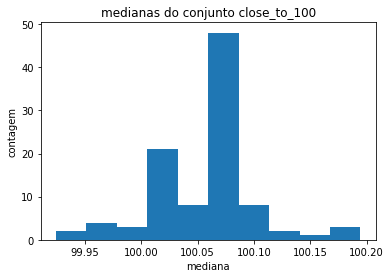

In [ ]:
medians1 = bootstrap_statistic(close_to_100, np.median, 100)
print("bootstrap_statistic(close_to_100, median, 100):")
fig = plt.figure()
plt.hist(medians1)
plt.xlabel("mediana")
plt.ylabel("contagem")
plt.title("medianas do conjunto close_to_100")
plt.show()
fig.savefig('bootstrap1.png', dpi=150)


você vê números, em sua maioria, muito próximos de 100. No entanto, se você observar:

bootstrap_statistic(far_from_100, median, 100):


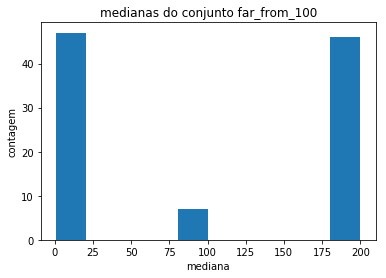

In [ ]:
medians2 = bootstrap_statistic(far_from_100, np.median, 100)
print("bootstrap_statistic(far_from_100, median, 100):")
fig = plt.figure()
plt.hist(medians2)
plt.xlabel("mediana")
plt.ylabel("contagem")
plt.title("medianas do conjunto far_from_100")
plt.show()
fig.savefig('bootstrap2.png', dpi=150)

você verá muitas medianas próximas de $0$ e outras próximas de $200$.

O desvio padrão do primeiro conjunto de medianas é próximo de $0$, enquanto o desvio padrão do segundo conjunto de medianas é próximo de $100$. (Esse caso extremo seria bem fácil de se descobrir, inspecionando manualmente os dados, mas em geral isso não é factível.)

# Erros Padrão de Coeficientes de Regressão

Podemos usar a mesma abordagem para estimar os erros padrão de nossos coeficientes de regressão. Nós repetidamente tomamos um `bootstrap_sample` dos nossos dados e estimamos o `beta` com base nessa amostra. Se o coeficiente correspondente a uma das variáveis independentes (digamos `num_friends`) não variar muito entre as amostras, podemos ter certeza de que nossa estimativa é relativamente segura. Se o coeficiente variar muito entre as amostras, não podemos ficar confiantes em nossa estimativa.

A única sutileza é que, antes da amostragem, precisamos zipar os dados `x` e `y` para garantir que os valores correspondentes das variáveis independentes e dependentes sejam amostrados juntos. Isso significa que `bootstrap_sample` retornará uma lista de pares `(x_i, y_i)`, que precisaremos remontar em um `x_sample` e um `y_sample`:

In [ ]:
def estimate_sample_beta(sample):
    """sample is a list of pairs (x_i, y_i)"""
    x_sample, y_sample = zip(*sample) # magic unzipping trick
    return estimate_beta(x_sample, y_sample)

In [ ]:
random.seed(0) # so that you get the same results as me

bootstrap_betas = bootstrap_statistic(list(zip(x, daily_minutes_good)),
                                      estimate_sample_beta,
                                      100)

Após o qual podemos estimar o desvio padrão de cada coeficiente:

In [ ]:
bootstrap_standard_errors = [
    np.std([beta[i] for beta in bootstrap_betas])
    for i in range(4)]

print("bootstrap standard errors:")
print("Std do coeficiente Beta do termo constante:", bootstrap_standard_errors[0])
print("Std do coeficiente Beta do termo num_amigos:", bootstrap_standard_errors[1])
print("Std do coeficiente Beta do termo horas_trabalho:", bootstrap_standard_errors[2])
print("Std do coeficiente Beta do termo phd:", bootstrap_standard_errors[3])

bootstrap standard errors:
Std do coeficiente Beta do termo constante: 0.9487719642256199
Std do coeficiente Beta do termo num_amigos: 0.06257240793036054
Std do coeficiente Beta do termo horas_trabalho: 0.1166351087514055
Std do coeficiente Beta do termo phd: 0.8548719625771628


Podemos usá-los para testar hipóteses como "$\beta_i$ é igual a zero?" Sob a hipótese nula $\beta_i = 0$ (e com nossas outras suposições sobre a distribuição de $\epsilon_i$), a estatística:

$$t_j = \frac{\hat{\beta_j}}{\hat{\sigma_j}}$$,

que é a nossa estimativa de $\beta_j$ dividido pela nossa estimativa de seu erro padrão, segue uma *distribuição t de Student* com "n-k graus de liberdade".

No módulo `t` da biblioteca `scipy.stats` há todas as funções associadas a distribuição t de Student. Assim, podemos usar a CDF dessa distribuição para calcular *p-valores* para cada coeficiente de mínimos quadrados a fim de indicar a probabilidade de observarmos esse valor se o coeficiente real fosse zero. 

In [ ]:
def p_value_t(beta_hat_j, sigma_hat_j, df): #df = degrees of freedom
    if beta_hat_j > 0:
        return 2 * (1 - t.cdf(beta_hat_j / sigma_hat_j, df))
    else:
        return 2 * t.cdf(beta_hat_j / sigma_hat_j, df)

In [ ]:
dof = 100 - 4 #n-k: amostras tem 100 valores e o modelo tem 4 preditores
for i in range(4):
    coef = beta[i]
    std = bootstrap_standard_errors[i]
    print("p_value(",coef,",",std,") =", p_value_t(coef, std, dof))

p_value( 30.619881701311712 , 0.9487719642256199 ) = 0.0
p_value( 0.9702056472470465 , 0.06257240793036054 ) = 0.0
p_value( -1.8671913880379478 , 0.1166351087514055 ) = 7.505131541677219e-29
p_value( 0.9163711597955347 , 0.8548719625771628 ) = 0.2864345276522129


Podemos também usar a distribuição normal. À medida que os graus de liberdade aumentam, a distribuição t se aproxima mais e mais de uma normal. Em uma situação como essa, onde $n$ é muito maior que $k$, podemos usar a CDF da distribuição normal. Vamos ver se o resultado persiste:

In [ ]:
def p_value_normal(beta_hat_j, sigma_hat_j):
    if beta_hat_j > 0:
        return 2 * (1 - norm.cdf(beta_hat_j / sigma_hat_j))
    else:
        return 2 * norm.cdf(beta_hat_j / sigma_hat_j)

In [ ]:
for i in range(4):
    coef = beta[i]
    std = bootstrap_standard_errors[i]
    print("p_value(",coef,",",std,") =", p_value_normal(coef, std))

p_value( 30.619881701311712 , 0.9487719642256199 ) = 0.0
p_value( 0.9702056472470465 , 0.06257240793036054 ) = 0.0
p_value( -1.8671913880379478 , 0.1166351087514055 ) = 1.1087885186419971e-57
p_value( 0.9163711597955347 , 0.8548719625771628 ) = 0.2837471357190793


(Em uma situação como essa, e provavemente como tudo que vimos até aqui, provavelmente estaríamos usando um software estatístico pronto que sabe bem como calcular os erros padrões exatos.)

Apesar disso, observe que os valores encontrados pelos dois métodos foram *muito* similares. Enquanto a maioria dos coeficientes tem p-valores muito pequenos (sugerindo que eles são realmente diferentes de zero), o coeficiente para "PhD" não é "significativamente" diferente de zero, o que torna provável que o coeficiente para "PhD" seja aleatório ao invés de significativo.

Em cenários de regressão mais elaborados, você às vezes deseja testar hipóteses mais elaboradas sobre os dados, como "pelo menos um dos $\beta_j$ é diferente de zero" ou "$\beta_1$ é igual a $\beta_2$ e $\beta_3$ é igual a $\beta_4$. Isso você pode fazer com um F-test, que, infelizmente, está fora do escopo deste curso, mas [é fácil de você aprender fora daqui](http://reliawiki.org/index.php/Multiple_Linear_Regression_Analysis).

## Regularização

Na prática, você costuma aplicar a regressão linear a conjuntos de dados com um grande número de variáveis. Isso cria algumas rugas extras. Primeiro, quanto mais variáveis você usar, maior a probabilidade de você sobreajustar (*overfit*) o seu modelo ao conjunto de treinamento. Em segundo lugar, quanto mais coeficientes diferentes de zero você tiver, mais difícil será entendê-los. Se o objetivo é *explicar* alguns fenômenos, um modelo esparso com três fatores pode ser mais útil do que um modelo um pouco melhor com centenas.

A regularização é uma abordagem na qual adicionamos ao termo de erro uma penalidade que aumenta à medida que o tamanho de $\beta$ aumenta. Em seguida, minimizamos o erro e a penalidade combinados. Quanto mais importância atribuímos ao termo de penalidade, mais desencorajamos grandes coeficientes.

Por exemplo, na regressão de crista (*ridge regression*), adicionamos uma penalidade proporcional à soma dos quadrados do `beta_i`. (Exceção feita ao `beta_0`, o termo constante, que normalmente não é penalizado.)

In [ ]:
# alpha is a *hyperparameter* controlling how harsh the penalty is
# sometimes it's called "lambda" but that already means something in Python
def ridge_penalty(beta, alpha):
    return alpha * np.dot(beta[1:], beta[1:])

def squared_error_ridge(x_i, y_i, beta, alpha):
    """estimate error plus ridge penalty on beta"""
    return error(x_i, y_i, beta) ** 2 + ridge_penalty(beta, alpha)

Que você pode plugar no gradiente descendente da maneira usual:

In [ ]:
def ridge_penalty_gradient(beta, alpha):
    """gradient of just the ridge penalty"""
    return [0] + [2 * alpha * beta_j for beta_j in beta[1:]]

def squared_error_ridge_gradient(x_i, y_i, beta, alpha):
    """the gradient corresponding to the ith squared error term
    including the ridge penalty"""
    regular_gradient = squared_error_gradient(x_i, y_i, beta)
    ridge_gradient = ridge_penalty_gradient(beta, alpha)
    return np.add(regular_gradient, ridge_gradient)
    #return vector_add(squared_error_gradient(x_i, y_i, beta),
    #                  ridge_penalty_gradient(beta, alpha))

    
def estimate_beta_ridge(x, y, alpha):
    """use gradient descent to fit a ridge regression
    with penalty alpha"""
    beta_initial = [random.random() for x_i in x[0]]
    return minimize_stochastic(partial(squared_error_ridge, alpha=alpha),
                               partial(squared_error_ridge_gradient,
                                       alpha=alpha),
                               x, y,
                               beta_initial,
                               0.001)

Com o alfa definido como zero, não há penalidade e obtemos os mesmos resultados de antes. Mas à medida que aumentamos o valor de alfa, o ajuste vai ficando pior, e o tamanho do beta menor.

In [ ]:
random.seed(0)
for alpha in [0.0, 0.01, 0.1, 1, 10]:
    beta = estimate_beta_ridge(x, daily_minutes_good, alpha=alpha)
    print("alpha:", alpha)
    print("beta:", beta)
    print("magnitude of beta:", np.linalg.norm(beta[1:]))
    print("r-squared:", multiple_r_squared(x, daily_minutes_good, beta))
    print()

alpha: 0.0
beta: [30.6198817   0.97020565 -1.86719139  0.91637116]
magnitude of beta: 2.2950901463816518
r-squared: 0.6800074955952596

alpha: 0.01
beta: [30.55985205  0.97306554 -1.86244246  0.93176656]
magnitude of beta: 2.298638157131645
r-squared: 0.6800102132970789

alpha: 0.1
beta: [30.89486018  0.94902752 -1.85017209  0.53251297]
magnitude of beta: 2.1464761971841027
r-squared: 0.6797276241305292

alpha: 1
beta: [30.66677891  0.908636   -1.6938673   0.09370161]
magnitude of beta: 1.9244702679726162
r-squared: 0.6757061537631814

alpha: 10
beta: [ 2.83728611e+01  7.30766086e-01 -9.21216318e-01 -1.84955517e-02]
magnitude of beta: 1.1760104858585188
r-squared: 0.5752138470466857



Em particular, o coeficiente de "PhD" desaparece à medida que aumentamos a penalidade, o que está de acordo com nosso resultado anterior de que o coeficiente dessa variável não é significativamente diferente de zero.

Normalmente, você deseja redimensionar seus dados antes de usar essa abordagem. Afinal, se você mudou "anos de experiência" para "séculos de experiência", seu coeficiente de mínimos quadrados aumentaria em um fator de 100 e, de repente, seria penalizado muito mais, mesmo que fosse o mesmo modelo.

Outra abordagem é a regressão *lasso*, que usa a penalidade:

In [ ]:
def lasso_penalty(beta, alpha):
    return alpha * sum(abs(beta_i) for beta_i in beta[1:])

Enquanto a penalidade *ridge* encolhe os coeficientes como um todo, a penalidade do laço tende a forçar os coeficientes a serem zero, o que a torna boa para aprender modelos esparsos. Infelizmente, essa abordagem não é passível de ser otimizada a partir do gradiente descendente, o que significa que não poderemos resolvê-la do zero.

## Para explorar

* Regressão tem uma teoria rica e expansiva por trás. Este é outro conteúdo sobre qual você deve considerar ler um livro ou, pelo menos, muitos artigos da Wikipédia.

* O `scikit-learn` possui [um módulo de modelos lineares](http://scikit-learn.org/stable/modules/linear_model.html) que fornece um modelo `LinearRegression` semelhante ao nosso, assim como de regressão *Ridge*, *Lasso* e outros tipos de regularização também.

* [Statsmodels](http://www.statsmodels.org/stable/index.html) é outro módulo do Python que contém (entre outras coisas) modelos de regressão linear.